In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 18
}  
def setfigform_simple(xlabel, ylabel=None, xlimit = (None,None), ylimit = (None, None), xticks=None):
    # plt.legend(fontsize = 16, frameon=False),
    plt.xlabel(xlabel, fontdict = font)
    plt.ylabel(ylabel, fontdict = font)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    if xticks is None:
        plt.xticks(fontsize = font['size'], fontname = "serif")
    else:
        plt.xticks(xticks, fontsize = font['size'], fontname = "serif")
    plt.yticks(fontsize = font['size'], fontname = "serif")
    plt.tick_params(direction="in")
    
line_color = [plt.colormaps["brg"](float(i)/float(3)) for i in range(3)]

In [2]:

def ReadReferenceF(filename):
    ofile_prob_E = open(filename,"r")
    Reference_dict = {}
    idx_jj = 0
    while(True):
        line = ofile_prob_E.readline()
        if not line:
            break

        line = ofile_prob_E.readline()
        bin_centers = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        jj = float(line.split()[-1].replace("kBT=",""))

        line = ofile_prob_E.readline()
        F = np.array([float(x) for x in line.split()])

        Reference_dict[jj]=np.stack([bin_centers, F])
    ofile_prob_E.close()
    return Reference_dict




In [3]:
def ReadReferenceF_potE(filename, readerror=False):
    ofile_prob_E = open(filename,"r")
    Reference_dict = {}
    idx_jj = 0
    while(True):
        line = ofile_prob_E.readline()
        if not line:
            break

        line = ofile_prob_E.readline()
        bin_centers = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        jj = float(line.split()[-1].replace("kBT=",""))

        line = ofile_prob_E.readline()
        F = np.array([float(x) for x in line.split()])
        if readerror:
            line = ofile_prob_E.readline()
            if not "ERROR" in line: 
                raise Exception("ERROR:: ERROR data not found in ", filename)
            line = ofile_prob_E.readline()
            errF = np.array([float(x) for x in line.split()])
        if readerror:
            Reference_dict[jj]=np.stack([bin_centers, F, errF])
        else:
            Reference_dict[jj]=np.stack([bin_centers, F])
    ofile_prob_E.close()
    return Reference_dict



In [4]:
ref_dirname = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt%dx%d-T4.0/latt%dx%d/"%(6,6,6,6)
Reference_dict_latt6 = ReadReferenceF(os.path.join(ref_dirname, "F-MAGN-REF.dat"))
Reference_dict_potE_latt6 = ReadReferenceF_potE(os.path.join(ref_dirname, "F-E-REF.dat"))


In [5]:
Expectation_Reference_dict_latt6 = {}
Expectation_Reference_dict_latt6["PotE"] = np.loadtxt(os.path.join(ref_dirname, "Expectation-E-REF.dat"), skiprows=1)

In [6]:
print(Expectation_Reference_dict_latt6["PotE"][:,0])
print(Expectation_Reference_dict_latt6["PotE"][:,1]/6**2)

[1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.8 3.2 3.6 4.  4.4 4.8 5.2 5.6 6.  8. ]
[-1.97026988 -1.96190508 -1.94176851 -1.90239366 -1.83474054 -1.72269063
 -1.56182895 -1.36432234 -1.00353936 -0.78041648 -0.64612818 -0.55484283
 -0.49675696 -0.44734715 -0.40840359 -0.37591402 -0.34839315 -0.2563414 ]


In [7]:

def ReadPredF(filename):
    ofile_prob_E = open(filename,"r")
    Reference_dict = {}
    idx_jj = 0
    while(True):
        line = ofile_prob_E.readline()
        if not line:
            break
        jj = float(line.split()[1].replace("alpha-1=","").replace(";",""))
        line = ofile_prob_E.readline()
        bin_centers = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        line = ofile_prob_E.readline()
        F = np.array([float(x) for x in line.split()])

        line = ofile_prob_E.readline()
        line = ofile_prob_E.readline()
        errF = np.array([float(x) for x in line.split()])

        Reference_dict[jj]=np.stack([bin_centers, F, errF])
    ofile_prob_E.close()
    return Reference_dict

# Conditional flow
- Condition: FM state
- Guidance coefficient $\gamma=1$
## Lattice size = 6x6
$\alpha=0.5, \alpha=1.0, \alpha=9.0$

In [8]:
# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']
colors = [plt.colormaps["gnuplot"](float(i)/4.) for i in range(4)]
print(colors, len(colors))

[(np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0)), (np.float64(0.5009794328681196), np.float64(0.015809545348320027), np.float64(0.9999810273487268), np.float64(1.0)), (np.float64(0.7084919084320762), np.float64(0.12647636278656021), np.float64(0.0), np.float64(1.0)), (np.float64(0.8677218312746247), np.float64(0.4268577244046407), np.float64(0.0), np.float64(1.0))] 4


In [9]:
import os

def read_prediction(dirname, lattice_dim):
    Pred_dict = {}
    Pred_dict["Lattice_dim"] = lattice_dim
    Pred_dict["Flow"] = ReadPredF(os.path.join(dirname, "FES-MAGN.dat"))
    Pred_dict["Flow-PotE"] = ReadPredF(os.path.join(dirname, "FES-E.dat"))
    Pred_dict["FlowProbs-PotE"] = ReadPredF(os.path.join(dirname, "PROB-E.dat"))

    diffstep_list = list(Pred_dict["Flow"].keys())
    return Pred_dict, diffstep_list

In [69]:
def plot_magn(Pred_dict, Reference_dict, Reference_L, Reference_Tlist=[2.4, 2.2, 1.], diffstep_list=[18, -1], ylimit=(None, 6)):
    plt.figure()
    for i, T in enumerate(Reference_Tlist):
        baseline = 0.
        plt.plot(Reference_dict[T][0], Reference_dict[T][1]-baseline, label=r"GT ($k_BT$=%.1f, L=%d)"%(T, Reference_L), c=colors[i], alpha=0.5)
        if T == 1.:
            plt.plot(-Reference_dict[1.][0], Reference_dict[1.][1]-baseline, label=r"GT ($k_BT$=%.1f, L=%d)"%(1., Reference_L), c=colors[i], alpha=0.5)
    for idx_diffstep, diffstep in enumerate(diffstep_list):
        baseline = 0.
        if diffstep == -1:
            color = colors[2]
        else:
            color = colors[idx_diffstep]
        plt.errorbar(Pred_dict["Flow"][list(Pred_dict["Flow"].keys())[diffstep]][0], Pred_dict["Flow"][list(Pred_dict["Flow"].keys())[diffstep]][1]-baseline, yerr=Pred_dict["Flow"][list(Pred_dict["Flow"].keys())[diffstep]][2], label=r"$\alpha$-1=%.1f"%(list(Pred_dict["Flow"].keys())[diffstep]), linestyle='none', c=color, marker="D", ms=3)

    setfigform_simple("Magnetization", "Free energy surface ($k_BT$)", ylimit=ylimit, xlimit=(-Reference_L**2*1.05, Reference_L**2*1.05))
    plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

In [11]:
def plot_potenergy(Pred_dict, Reference_dict, Reference_L, Reference_Tlist=[2.4, 2.2, 1.], diffstep_list=[18, -1]):
    plt.figure()
    for i, T in enumerate(Reference_Tlist):
        # if T in [8.0]:
        #     continue
        plt.plot(Reference_dict[T][0]/Reference_L**2, Reference_dict[T][1], label=r"GT ($k_BT$=%.1f, L=%d)"%(T, Reference_L), c=colors[i], alpha=0.5)
    for idx_diffstep, diffstep in enumerate(diffstep_list):
        if diffstep == -1:
            color = colors[2]
        else:
            color = colors[idx_diffstep]
        plt.errorbar(Pred_dict["Flow-PotE"][list(Pred_dict["Flow-PotE"].keys())[diffstep]][0]/Reference_L**2, Pred_dict["Flow-PotE"][list(Pred_dict["Flow-PotE"].keys())[diffstep]][1], yerr=Pred_dict["Flow-PotE"][list(Pred_dict["Flow-PotE"].keys())[diffstep]][2], label=r"$\alpha$-1=%.1f"%(list(Pred_dict["Flow-PotE"].keys())[diffstep]), linestyle='none', c=color, marker="D", ms=3)

    setfigform_simple("Potential energy (J)", "Negative likelihood")
    plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
def calc_expectation_potenergy(Pred_dict, diffstep_list):
    Pred_dict["FlowExpectations-PotE"] = []
    for diffstep in range(80):
        Jac_Expectation = Pred_dict["FlowProbs-PotE"][list(Pred_dict["Flow-PotE"].keys())[diffstep]][0]
        var_Prob = Pred_dict["FlowProbs-PotE"][list(Pred_dict["Flow-PotE"].keys())[diffstep]][2]**2
        err_Expectation = np.sqrt(Jac_Expectation*var_Prob*Jac_Expectation).sum()
        Expectation = (Pred_dict["FlowProbs-PotE"][diffstep_list[diffstep]][1]*Pred_dict["FlowProbs-PotE"][diffstep_list[diffstep]][0]).sum()
        Pred_dict["FlowExpectations-PotE"].append([diffstep_list[diffstep], Expectation, err_Expectation])

    Pred_dict["FlowExpectations-PotE"] = np.array(Pred_dict["FlowExpectations-PotE"])

In [13]:
def plot_expactation_potenergy(Pred_dict, Reference_dict, Reference_L, Benchmark_T=[1.,], Benchmark_diffstep=[-1]):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(Reference_dict["PotE"][:,0], Reference_dict["PotE"][:,1]/Reference_L**2, c="k")
    assert len(Benchmark_T) == len(Benchmark_diffstep)
    for i in range(len(Benchmark_T)):
        plt.errorbar(Benchmark_T[i], Pred_dict["FlowExpectations-PotE"][Benchmark_diffstep[i],1]/Reference_L**2, yerr=Pred_dict["FlowExpectations-PotE"][Benchmark_diffstep[i],2]/Reference_L**2, c="blue", fmt="D", ms=8)
    plt.axvline(2/np.log(1+np.sqrt(2)), linestyle="--", c="k")
    setfigform_simple("$kBT$", "$<U>$", xlimit=(None,6))
    plt.ylim((-2.2,-400/36**2))
    plt.subplot(122)
    plt.errorbar(Pred_dict["FlowExpectations-PotE"][:,0], Pred_dict["FlowExpectations-PotE"][:,1]/Reference_L**2, yerr=Pred_dict["FlowExpectations-PotE"][:,2]/Reference_L**2, c="blue", fmt="-")
    setfigform_simple(r"$\alpha$-1", "$<U>$")
    plt.ylim((-2.2,-400/36**2))
    plt.tight_layout()

In [14]:
def plot_expactation_potenergy_cmapbydifftime(Pred_dict, Reference_dict, Reference_L, Benckmark_T=[1.,], Benckmark_diffstep=[-1]):
    plt.figure(figsize=(7,5))
    Reference_idx = np.array([np.where(Expectation_Reference_dict_latt6["PotE"][:,0] == T)[0][0] for T in Benchmark_T])
    # plt.errorbar(Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,0], Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,1]/Reference_L**2, yerr=Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,2]/Reference_L**2, fmt='none', ecolor='gray', capsize=3)
    # plt.scatter(Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,0], Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,1]/Reference_L**2, c=Benckmark_T, cmap="gnuplot", marker="o", )
    # x_smooth = np.linspace(Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,0].min(), Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,0].max(), 200)
    # y_smooth = np.interp(x_smooth, Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep,0], Reference_dict["PotE"][Reference_idx,1]/Reference_L**2)
    # plt.plot(x_smooth, y_smooth, c="grey")
    # setfigform_simple(r"$\alpha$-1", "$<U>$")
    # cbar = plt.colorbar()
    # cbar.set_label('$k_BT$', fontsize=16)
    plt.plot(Reference_dict["PotE"][:,0], Reference_dict["PotE"][:,1]/Reference_L**2, c="k")
    assert len(Benckmark_T) == len(Benckmark_diffstep)
    for i in range(len(Benckmark_T)):
        plt.errorbar(Benckmark_T[i], Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep[i],1]/Reference_L**2, yerr=Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep[i],2]/Reference_L**2, ecolor="grey", fmt="none", capsize=3)

    plt.scatter(Benckmark_T, [Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep[i],1]/Reference_L**2 for i in range(len(Benckmark_T))], c=[Pred_dict["FlowExpectations-PotE"][Benckmark_diffstep[i],0] for i in range(len(Benckmark_T))], marker="o", cmap="gnuplot")
    plt.axvline(2/np.log(1+np.sqrt(2)), linestyle="--", c="k")
    setfigform_simple(r"$k_BT$", "$<U>$", xlimit=(None,6))
    plt.ylim((-2.2,-400/36**2))
    cbar = plt.colorbar()
    cbar.set_label(r'$\alpha-1$', fontsize=18)
    cbar.ax.tick_params(labelsize=18) 
    plt.tight_layout()

In [15]:
Pred_dict_c1, difftime_list = read_prediction("clf/guidanceM/val_baseline_latt6x6/epoch159_IntStep80_AMax10_clspd1.0_scoreG1.0/", (6,6))

In [16]:
calc_expectation_potenergy(Pred_dict_c1, difftime_list)

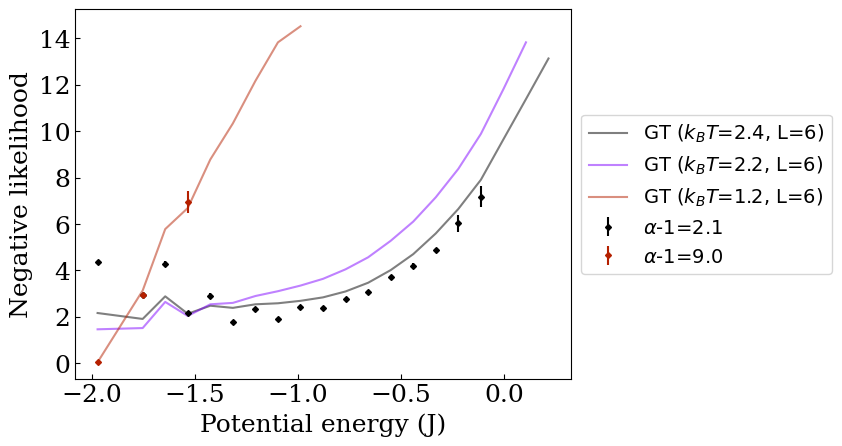

In [17]:
plot_potenergy(Pred_dict_c1, Reference_dict_potE_latt6, 6, Reference_Tlist=[2.4, 2.2, 1.2])

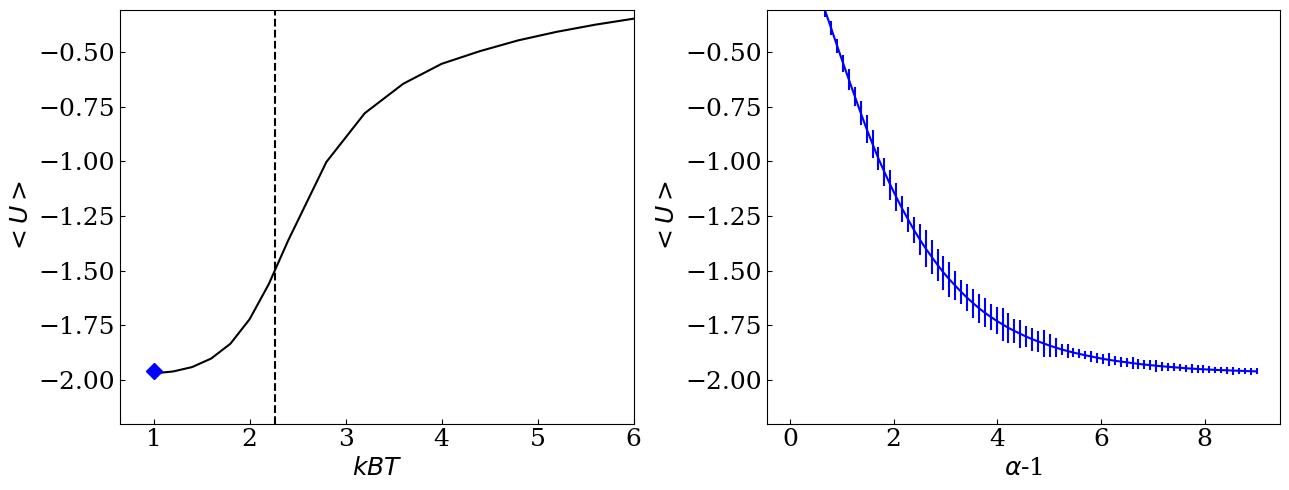

In [18]:
plot_expactation_potenergy(Pred_dict_c1, Expectation_Reference_dict_latt6, 6)

In [19]:

Pred_dict_ = {}
Pred_dict_["guidance_class"] = "pd1.0"
Pred_dict_["shuffle_freq"] = 0.0
Pred_dict_["guidance_coeff"] = 1.0
Pred_dict_["Predictions"] = Pred_dict_c1


In [20]:

Pred_dict_c2, difftime_list = read_prediction("clf/guidanceEM/val_baseline_latt6x6/epoch208_IntStep640_AMax10_clsT2.4L6_scoreG0.4", (6,6))

In [21]:
calc_expectation_potenergy(Pred_dict_c2, difftime_list)

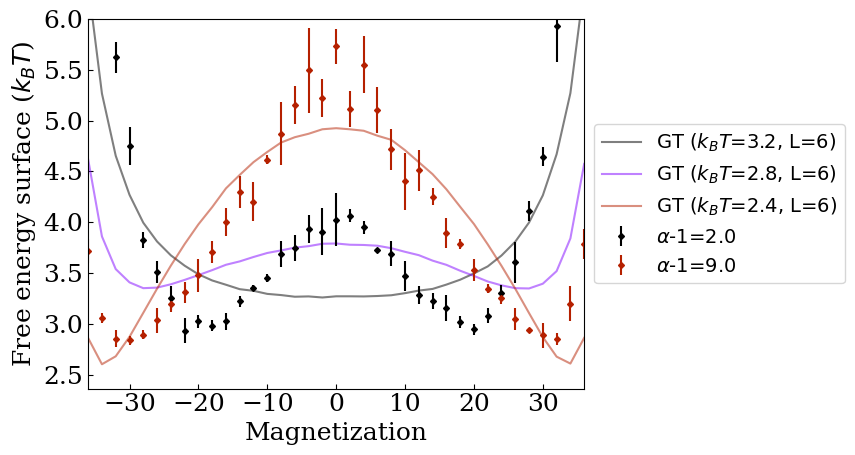

In [22]:
plot_magn(Pred_dict_c2, Reference_dict_latt6, 6, Reference_Tlist=[3.2, 2.8, 2.4])

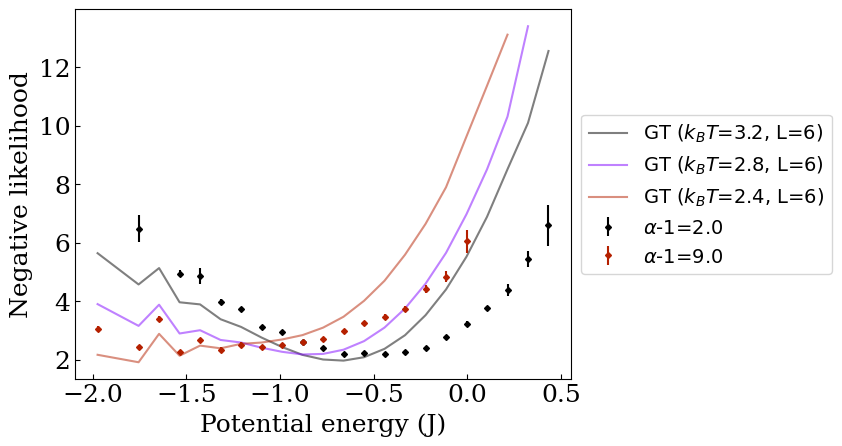

In [23]:
plot_potenergy(Pred_dict_c2, Reference_dict_potE_latt6, 6, Reference_Tlist=[3.2, 2.8, 2.4])

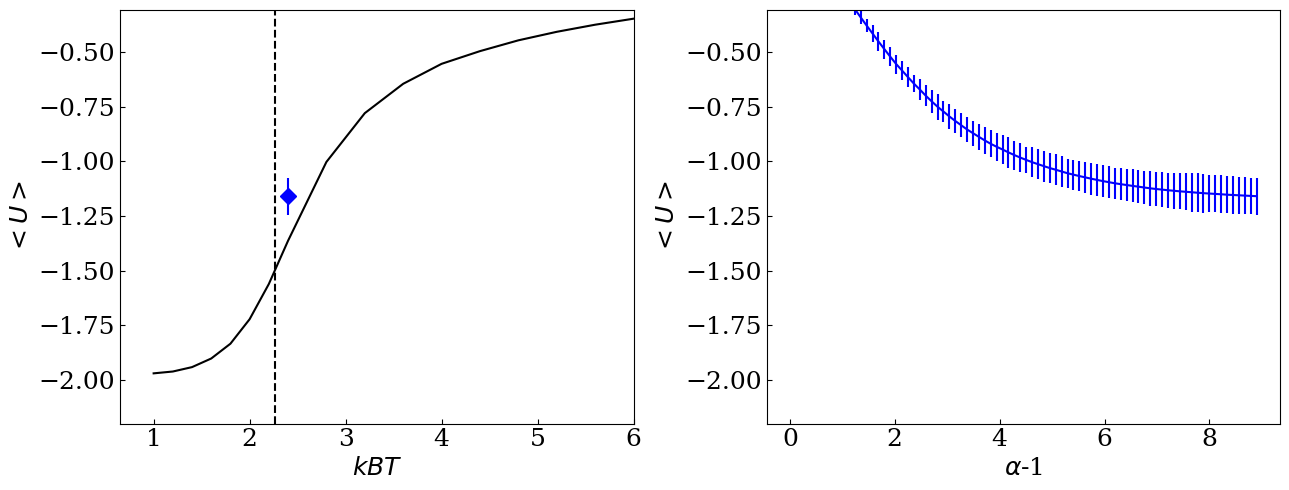

In [25]:
plot_expactation_potenergy(Pred_dict_c2, Expectation_Reference_dict_latt6, 6, Benchmark_T=[2.4], Benchmark_diffstep=[-1])

In [26]:

Pred_dict_ = {}
Pred_dict_["T2.4L6"] = {}
Pred_dict_["T2.4L6"]["guidance_data"] = "T2.4L6"
Pred_dict_["T2.4L6"]["shuffle_freq"] = 0.0
Pred_dict_["T2.4L6"]["guidance_coeff"] = 0.4
Pred_dict_["T2.4L6"]["Predictions"] = Pred_dict_c2


## Lattice size = 12x12

In [27]:
Pred_dict_withconditions_L12 = []

In [28]:
ref_dirname = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt%dx%d-T4.0/latt%dx%d/"%(12,12,12,12)
Reference_dict_latt12 = ReadReferenceF(os.path.join(ref_dirname, "F-MAGN-REF.dat"))
Reference_dict_potE_latt12 = ReadReferenceF_potE(os.path.join(ref_dirname, "F-E-REF.dat"))
Expectation_Reference_dict_latt12 = {}
Expectation_Reference_dict_latt12["PotE"] = np.loadtxt(os.path.join(ref_dirname, "Expectation-E-REF.dat"), skiprows=1)

In [29]:
Pred_dict_c1_latt12, difftime_list = read_prediction("clf/guidanceEM/val_baseline_latt12x12/epoch208_IntStep640_AMax10_clsT2.4L6_scoreG0.4", (12,12))

In [30]:
calc_expectation_potenergy(Pred_dict_c1_latt12, difftime_list)

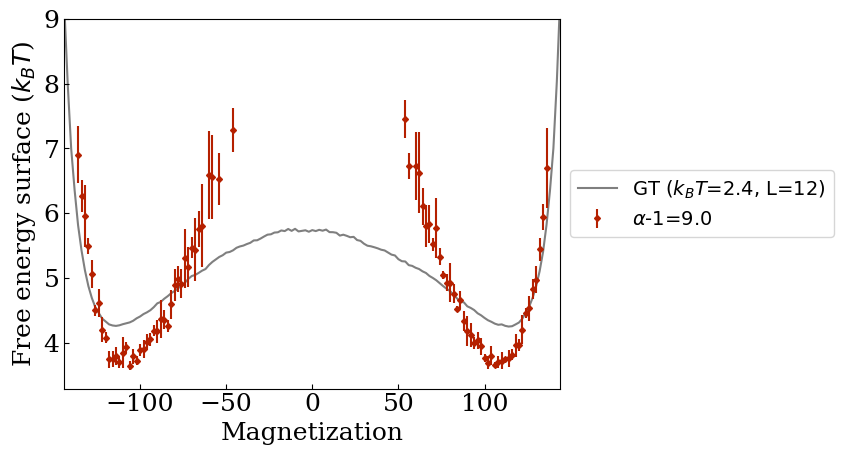

In [31]:
plot_magn(Pred_dict_c1_latt12, Reference_dict_latt12, 12, Reference_Tlist=[2.4], diffstep_list=[-1], ylimit=(None, 9))

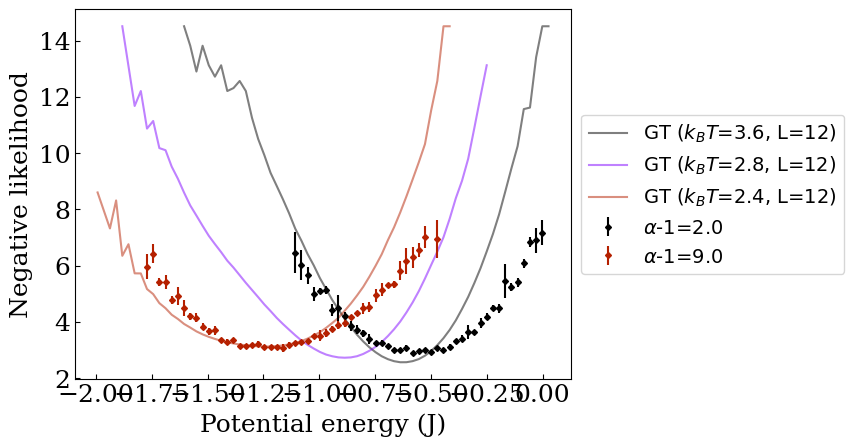

In [32]:
plot_potenergy(Pred_dict_c1_latt12, Reference_dict_potE_latt12, 12, Reference_Tlist=[3.6, 2.8, 2.4])

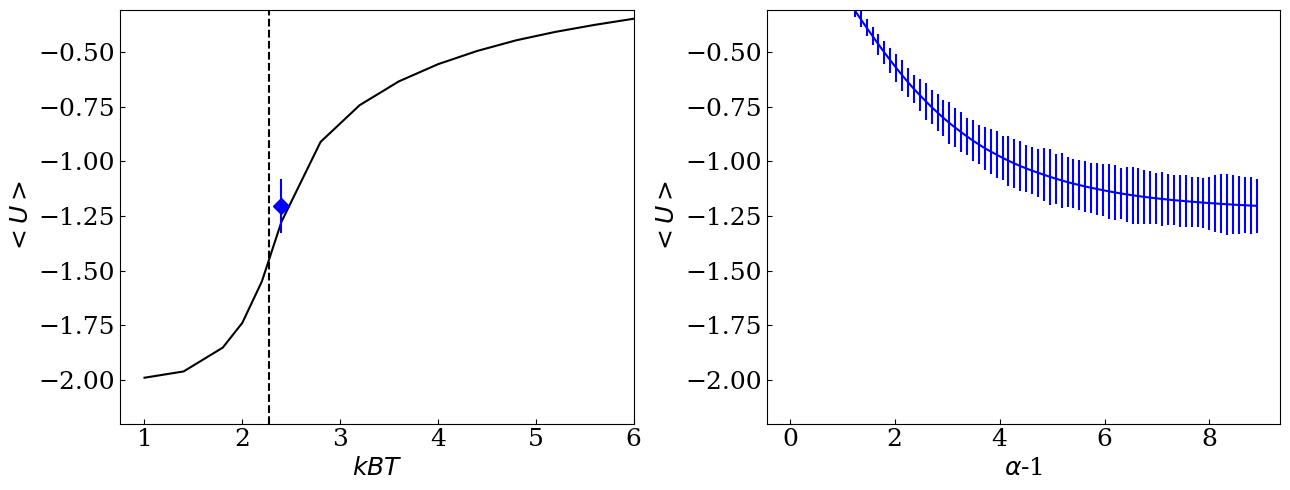

In [33]:
plot_expactation_potenergy(Pred_dict_c1_latt12, Expectation_Reference_dict_latt12, 12, Benchmark_T=[2.4,], Benchmark_diffstep=[-1])

In [34]:

Pred_dict_["T2.4L12"] = {}
Pred_dict_["T2.4L12"]["guidance_data"] = "T2.4L6"
Pred_dict_["T2.4L12"]["shuffle_freq"] = 0.0
Pred_dict_["T2.4L12"]["guidance_coeff"] = 0.4
Pred_dict_["T2.4L12"]["Predictions"] = Pred_dict_c1_latt12



In [37]:
import json
from copy import deepcopy
def ndarray_to_list(d_):
    d = deepcopy(d_)
    if isinstance(d, dict):
        # 如果是字典，递归处理每个键
        return {k: ndarray_to_list(v) for k, v in d.items()}
    elif isinstance(d, list):
        # 如果是列表，递归处理每个元素
        return [ndarray_to_list(i) for i in d]
    elif isinstance(d, np.ndarray):
        # 如果是 ndarray，转换为列表
        return d.tolist()
    else:
        # 如果是其他类型，直接返回
        return d

o_Pred_dict_ = ndarray_to_list(Pred_dict_)
with open('Pred_dict.json', 'w', encoding='utf-8') as json_file:
    json.dump(o_Pred_dict_, json_file, ensure_ascii=False, indent=4)
del o_Pred_dict_

([], [])

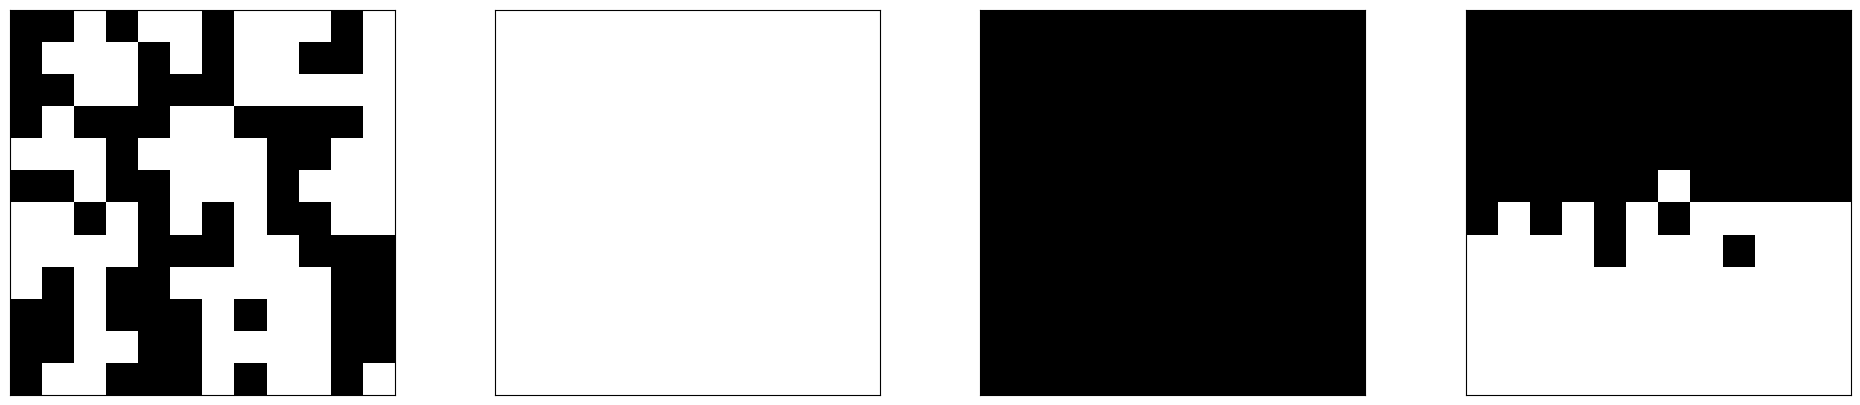

In [55]:
plt.figure(figsize=(24,5))
plt.subplot(141)
r1 = np.random.choice([-1,1], size=(12,12))
_ = plt.imshow(r1, cmap='Greys', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])
plt.subplot(142)
r2 = np.ones((12,12))*-1
_ = plt.imshow(r2, cmap='Greys', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])
plt.subplot(143)
r3 = np.ones((12,12))
_ = plt.imshow(r3, cmap='Greys', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])
plt.subplot(144)
r4 = np.ones((12,12))*-1
for i in range(12):
    for j in range(12):
        rboundary = np.random.rand()*0.2+0.4
        if i < rboundary*12:
            r4[i,j]=1

_ = plt.imshow(r4, cmap='Greys', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])



## Lattice size = 36x36

In [56]:
ref_dirname = "/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt%dx%d-T4.0/latt%dx%d/"%(36,36,36,36)
Reference_dict_latt36 = ReadReferenceF(os.path.join(ref_dirname, "F-MAGN-REF.dat"))
Reference_dict_potE_latt36 = ReadReferenceF_potE(os.path.join(ref_dirname, "F-E-REF.dat"))


In [57]:
Expectation_Reference_dict_latt36 = {}
Expectation_Reference_dict_latt36["PotE"] = np.loadtxt(os.path.join(ref_dirname, "Expectation-E-REF.dat"), skiprows=1)

In [58]:
Pred_dict_c1_latt36, difftime_list = read_prediction("clf/guidanceM/val_baseline_latt36x36/epoch159_IntStep80_AMax10_clspd1.0_scoreG1.0_testsymm1", (36,36))

In [59]:
Pred_dict_latt36, difftime_list = read_prediction("clf/guidanceM/val_baseline_latt36x36/epoch159_IntStep80_AMax10_clspd1.0_scoreG0.0/", (36,36))

In [60]:
calc_expectation_potenergy(Pred_dict_c1_latt36, difftime_list)
calc_expectation_potenergy(Pred_dict_latt36, difftime_list)

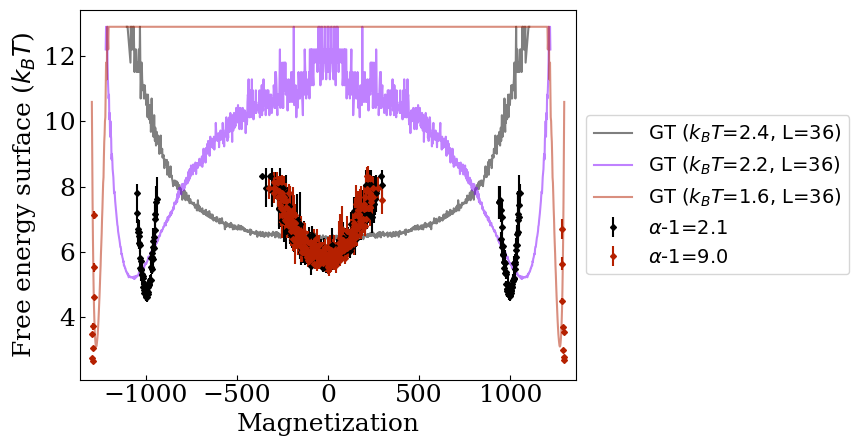

In [77]:
plot_magn(Pred_dict_c1_latt36, Reference_dict_latt36, 36, Reference_Tlist=[2.4, 2.2, 1.6], ylimit=(None,None))

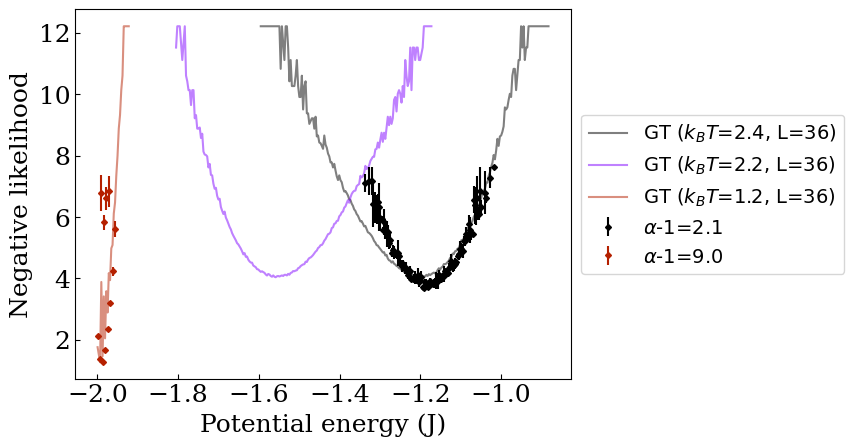

In [66]:
plot_potenergy(Pred_dict_c1_latt36, Reference_dict_potE_latt36, 36, Reference_Tlist=[2.4, 2.2, 1.2])

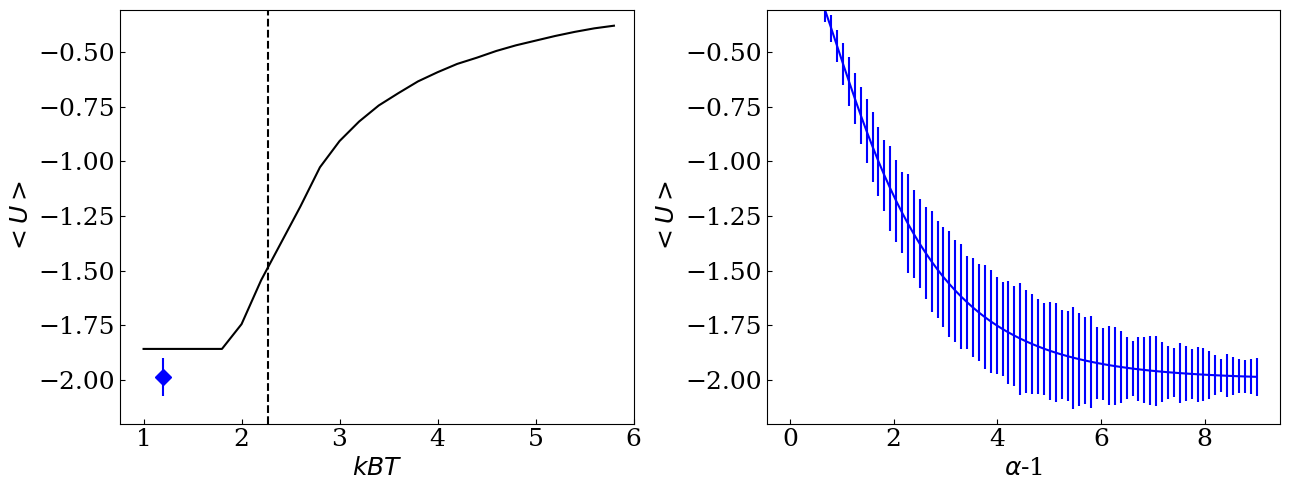

In [64]:
plot_expactation_potenergy(Pred_dict_c1_latt36, Expectation_Reference_dict_latt36, 36, Benchmark_T=[1.2,], Benchmark_diffstep=[-1])

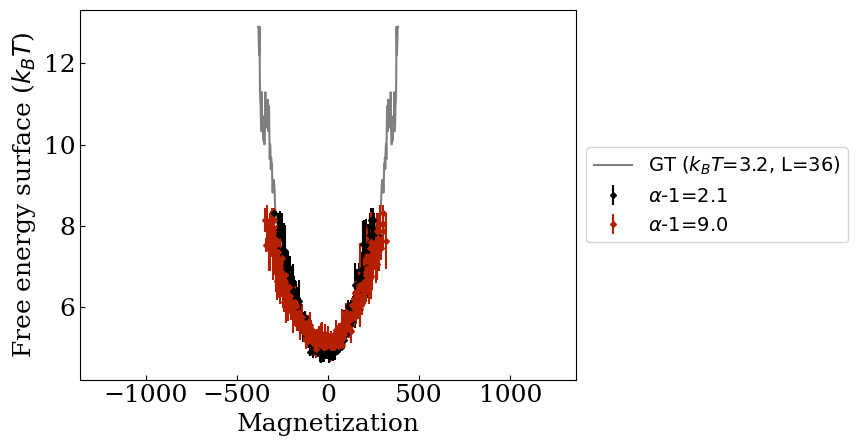

In [72]:
plot_magn(Pred_dict_latt36, Reference_dict_latt36, 36, Reference_Tlist=[3.2], ylimit=(None,None))

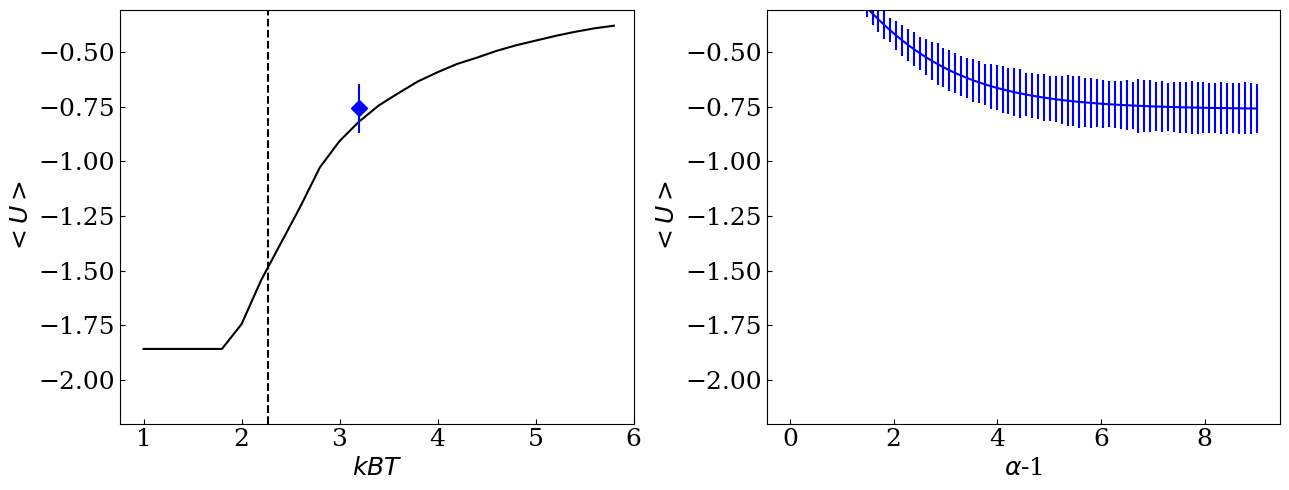

In [65]:

plot_expactation_potenergy(Pred_dict_latt36, Expectation_Reference_dict_latt36, 36, Benchmark_T=[3.2,], Benchmark_diffstep=[-1])

In [ ]:

Pred_dict_ = {}
Pred_dict_["guidance_class"] = "pd1.0"
Pred_dict_["shuffle_freq"] = 0.0
Pred_dict_["guidance_coeff"] = 1.0
Pred_dict_["Predictions"] = Pred_dict_c1_latt36


## The ground truth

In [ ]:
plt.plot(Expectation_Reference_dict_latt6["PotE"][:,0], Expectation_Reference_dict_latt6["PotE"][:,1]/6**2, c="k")
plt.plot(Expectation_Reference_dict_latt36["PotE"][:,0], Expectation_Reference_dict_latt36["PotE"][:,1]/36**2)